Note: marking areas possibly affected by the 100+ transition with ???. Clean before posting.

Hello!  I'm Chris Porter, and in this code walkthrough, we'll focus on applying Qiskit Runtime to a problem that cannot be solved on open systems???. Specifically, we will determine the ground state energy of the water molecule using the variational quantum eigensolver (or VQE). We won't step through the meaning of every component of VQE, and will rather focus on the use of Runtime. If you need more background on the components of VQE (like the hamiltonian, ansatz, and classical optimizer), please see the premium courses linked below this video.
We're importing a number of drivers here, and the electronic structure problem. We will also import the FreezeCore transformer, since the oxygen has core electrons that can be frozen out of the calculation.

In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

When we define our molecule, with an oxygen and two hydrogen atoms, we specify the geometry of the molecule in units of Angstroms. The net charge of a free water molecule is 0, and the spin multiplicity is always 2S+1, which for zero-spin water (no unpaired electrons) gives us 1.
We'll specify that we want to freeze out the core electrons in the electronic structure problem. The quantum operator that we get is written in terms of second quantized (like creation and annihilation) operators. Clearly, this hamiltonian is describing electrons in orbitals, which are indistinguishable and obey fermionic statistics. The qubits in a quantum computer are distinguishable and obey different statistics. We have to go through a mapping process to fix this, and we typically map to Paulis. One can use several mappers. Here we are using the Parity mapper instead of the Jordan-Wigner mapper because it allows for this two-qubit reduction, and saves us some qubits. We'll print the operator that comes out, for discussion purposes.

In [2]:
molecule = Molecule([["O",[0.0,0.0,0.0]],["H", [0.757,0.586,0.0]], ["H", [-0.757,0.586,0.0]]], charge = 0, multiplicity = 1)
driver = ElectronicStructureMoleculeDriver(molecule, basis = "sto3g", driver_type = ElectronicStructureDriverType.PYSCF)
es_problem = ElectronicStructureProblem(driver, transformers=[FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[])])
second_q_ops = es_problem.second_q_ops()
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
mapper = ParityMapper()
converter = QubitConverter(mapper = mapper, two_qubit_reduction = True)
qubit_op = converter.convert(second_q_ops["ElectronicEnergy"],num_particles = es_problem.num_particles)
print(qubit_op)

-18.593736381215592 * IIIIIIIIII
+ 1.16886534588696 * IIIIIIIIIZ
- 0.060577552871378414 * IIIIIIIZXX
- 0.060577552871378414 * IIIIIIIIYY
+ 0.1389947546906709 * IIIIIZXXXX
+ 0.1389947546906709 * IIIIIIYXXY
+ 0.8131613222582217 * IIIIIIIIZZ
+ 0.1916880826019872 * IIIIIXXXXZ
+ 0.1916880826019872 * IIIIIYXXYI
+ 0.8227931940302332 * IIIIIIIZZI
+ 0.11369424413594482 * IIIIIZXXZI
+ 0.11369424413594482 * IIIIIIYYII
+ 0.8197802091581958 * IIIIIIZZII
+ 0.3854230117318295 * IIIIIZZIII
+ 0.3769723335135046 * IIIIIZIIII
+ 1.1688653458869598 * IIIIZIIIII
- 0.0605775528713784 * IIZXXIIIII
- 0.0605775528713784 * IIIYYIIIII
+ 0.1389947546906709 * ZXXXXIIIII
+ 0.1389947546906709 * IYXXYIIIII
+ 0.8131613222582218 * IIIZZIIIII
+ 0.19168808260198705 * XXXXZIIIII
+ 0.19168808260198705 * YXXYIIIIII
+ 0.8227931940302327 * IIZZIIIIII
+ 0.1136942441359449 * ZXXZIIIIII
+ 0.1136942441359449 * IYYIIIIIII
+ 0.819780209158195 * IZZIIIIIII
+ 0.38542301173183025 * ZZIIIIIIII
+ 0.37697233351350407 * ZIIIIIIIII
+ 0.1251

The full hamiltonian has several hundred terms, which is why it isn't all shown. Note that each term has a string of 10 operators, meaning this calculation requires 10 qubits. As of the beginning of 2023, the largest open systems offered by IBM have 7 qubits???, so only IBM Quantum Network members can do this problem on a real IBM Quantum System. This system is also large enough that one can start to see the importance of things like choosing a good optimizer, and a good ansatz, which will only become more important as you move on to larger molecules. Here, we will import several choices of ansatz and optimizer, but we will initially select the TwoLocal with the specified rotation and entanglement blocks, and the COBYLA optimizer.

In [3]:
from qiskit.circuit.library import PauliTwoDesign, TwoLocal, EfficientSU2
from qiskit_nature.circuit.library import HartreeFock
init_state = HartreeFock(es_problem.num_spin_orbitals, es_problem.num_particles, converter)
#init_state = None
rotation_blocks = ['ry','rx']
entanglement_blocks = ['crx']
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, 'sca', insert_barriers = False,initial_state = init_state)

from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
optimizer = COBYLA(maxiter=50)

We start by importing estimator, Qiskitruntimeservice, session, and options all from qiskit_ibm_runtime. We'll specify the service to be ...
Now we'll specify options for our estimator. We can specify the number of shots, which is self explanatory. We can also specify these levels of resilience and optimization. As I'm sure you've heard before, resilience refers to error mitigation techniques being employed. 0 - no error mitigation. 1 -default, twirled readout error extinction, 2 - Zero noise extrapolation, and 3 - Probabilistic error correction. As you increase the number, increase the resilience to error, you also increase the cost in terms of the number of calculations and machine time. Similarly, higher optimization levels means more optimized circuits, but at the expense of longer transpilation times. Again, 0 means no optimization, 1 is the default, and so on.
Then we will specify that our session will use a the ibmq_qasm_simulator as a backend, and we'll add in these options we've specified. We'll also add a line to check the defaults on those options

In [4]:
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session, Options

service = QiskitRuntimeService(channel = "ibm_quantum")

options = Options()
options.execution.shots = 2000
options.resilience_level = 0
options.optimization_level = 0
estimator = Estimator(session=Session(service, backend = "ibmq_qasm_simulator"), options=options)

print(Options._DEFAULT_RESILIENCE_LEVEL,Options._DEFAULT_OPTIMIZATION_LEVEL)

1 3


Let's define a callback function so we can see how our calculation is converging.

In [5]:


counts = []
values = []

def store_intermediate_result(eval_counts, parameters, mean, std):
    counts.append(eval_counts)
    values.append(mean)

Finally, we'll import VQE, add in our estimator, ansatz, optimizer, and callback as arguments, and run it.

In [6]:
from qiskit.algorithms.minimum_eigensolvers import VQE

vqe = VQE(estimator, ansatz, optimizer,callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(qubit_op)
    
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 50,
    'eigenvalue': -21.481614764013425,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fccc0b44790>,
    'optimal_parameters': {   ParameterVectorElement(θ[48]): 5.595617854505051,
                              ParameterVectorElement(θ[49]): -5.155205254761005,
                              ParameterVectorElement(θ[50]): 0.7938238306478569,
                              ParameterVectorElement(θ[51]): 2.1806058189592807,
                              ParameterVectorElement(θ[52]): -2.171004358306475,
                              ParameterVectorElement(θ[53]): -5.452772464472964,
                              ParameterVectorElement(θ[54]): -5.912757263076112,
                              ParameterVectorElement(θ[55]): -4.110433960187846,
                              ParameterVectorElement(θ[56]): 0.079839313707871,
                              ParameterVectorElement(θ[57]): 5.66

There are a lot of outputs here. We are most interested in the eigenvalue, which is the ground state energy. We might also care about optimizer time or function evaluations, if we're concerned with resources being used. The list of parameter vector elements is telling us the choices for our variational circuit (in our ansatz) that ended up minimizing the energy. Again, please see the introduction to VQE linked below this video if you want to know more about these outputs.
At this moment, we don't really know if the eigenvalue we obtained is a good or a poor estimate of the ground state energy of the water molecule. As long as we are working on relatively small systems, we can check our results using exact numerical eigensolvers. Of course, as we approach quantum advantage, we will evetually solve problems on quantum computers that cannot be solved using classical numerical eigensolvers. For now, we can calculate the exact result for reference:

In [9]:
from qiskit.algorithms import NumPyEigensolver
exact = NumPyEigensolver()
exact_run = exact.compute_eigenvalues(qubit_op)
print(exact_run)

{   'aux_operator_eigenvalues': None,
    'eigenstates': ListOp([VectorStateFn(Statevector([-1.86697906e-16+1.83265488e-16j,
              2.03263047e-18+1.02511925e-17j,
              8.01658713e-18+2.98353642e-17j, ...,
              2.06656688e-16-8.49882491e-17j,
             -7.67516027e-18+1.12586790e-17j,
             -1.09080424e-17-4.13058195e-19j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-23.54449724])}


These energies are fairly close. But note that this is not the entire electronic energy, because the core orbitals have been removed from the Hamiltonian, and so cannot show up in the calculation on the quantum computer. But the energies of the core orbitals of all atoms are well-known, and the information is stored (albeit well-hidden) in the electronic structure problem. Scrolling to the bottom, we see that inner core electrons on the Oxygen molecule is -60.66 hartrees.

In [10]:
print(es_problem.grouped_property_transformed._properties["ElectronicEnergy"])

ElectronicEnergy
	(AO) 1-Body Terms:
		Alpha
		<(7, 7) matrix with 31 non-zero entries>
		[0, 0] = -27.95558616689127
		[0, 1] = -6.894975938645062
		[0, 3] = -0.021475167501065297
		[0, 5] = -1.5843970850556315
		[0, 6] = -1.5843970850556315
		... skipping 26 entries
		Beta
		<(7, 7) matrix with 31 non-zero entries>
		[0, 0] = -27.95558616689127
		[0, 1] = -6.894975938645062
		[0, 3] = -0.021475167501065297
		[0, 5] = -1.5843970850556315
		[0, 6] = -1.5843970850556315
		... skipping 26 entries
	(AO) 2-Body Terms:
		Alpha-Alpha
		<(7, 7, 7, 7) matrix with 1245 non-zero entries>
		[0, 0, 0, 0] = 4.785065404705503
		[0, 0, 0, 1] = 0.7413803519734079
		[0, 0, 0, 5] = 0.17175024750675835
		[0, 0, 0, 6] = 0.17175024750675835
		[0, 0, 1, 0] = 0.741380351973408
		... skipping 1240 entries
		Beta-Alpha
		Same values as the corresponding primary-spin data.
		Beta-Beta
		Same values as the corresponding primary-spin data.
		Alpha-Beta
		Same values as the corresponding primary-spin data.
	(MO) 1

Note that this shift is a constant. If we were varying a parameter like the OH bond length or the bond angle, trying to find the lowest-energy geometry of the molecule, all choices of bond angle and bond length would be shifted by the same amount, and we wouldn't even need to take this shift into account. Here, we'll go ahead and add that shift to  our values, since we are calculating the ground state energy, explicitly.
We'll record these values with the subscript _freeze appended, so we can compare them, and we'll shift the values we've obtained by the constant from the frozen core electrons.

In [11]:
result_freeze=result
values_freeze = values
for i in range(len(values)):
    values_freeze[i] = values[i]-60.66177520599246
counts_freeze = counts

Note that when we found the exact solution numerically, we were using the Hamiltonian with the core electrons frozen out. So the exact ground state is the -22.4 hartrees we found, shifted by the -60.66 hartrees from the frozen core. So we'll plot our target energy as -84.2 hartrees.

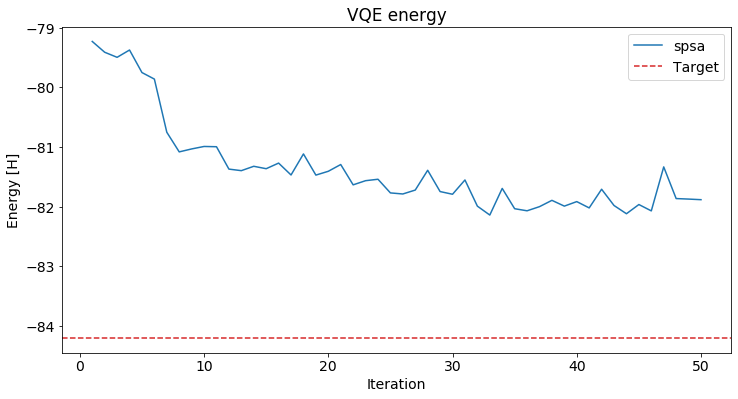

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(counts_freeze, values_freeze, label='spsa')
plt.axhline(y=-84.206, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [13]:
#Not to be shown in code walkthrough; just for me to have.
import numpy
f = open("qasm_spsa_H2O", "w+")
f.write("# optimization_step Energy\n")        # column names
numpy.savetxt(f, numpy.array([counts_freeze, values_freeze]).T)
#x, y = numpy.loadtxt("trialdata", unpack=True)

That was a fine test run on the qasm simulator, but we want to send our problem to real quantum devices and we want to do it using runtime so we can use automated optimization and resilience.

We will load our account:

In [14]:
from qiskit import IBMQ
provider = IBMQ.load_account()

/home/porter284/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  
/home/porter284/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  


Great. Now, we'll import from qiskit_ibm_runtime....
We're on a real device, so we definitely want to use SPSA as our optimizer. We'll start with just 50 iterations; this is not likely to be enough to get good convergence, but it will be enough for us to see how automated optimization and resilience work. We'll set up the service as the QuantumRuntimeService...
Let's just reset the counts and values.
This time we'll use ibm_washington as our backend.
Previously, we set our session as an argument of the estimator. That was fine, but what we're going to do now is set with Session (...) and specify our estimator, options, and VQE calculation in side the session. The reason for this is simple: if we wrap all our optimizer iterations inside a single session, then the session (and all the optimization steps therein) only sit in the queue once. If we start a session in the argument of the estimator, then each optimization step is submitted as a new job and waits in the queue every time. So, on a real device, any time there are more than a few iterations of an optimizer, you'll want to open a session this way.
Here, I've set options to be resilience and optimization both 0, as opposed to the defaults. This is for speed in this demonstration; you'll probably use the defaults in most situations.
Everything else is the same, except that we haven't set estimator, so in the argument of VQE, we'll type Estimator(...)

In [15]:
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session, Options

optimizer = SPSA(maxiter = 50)

counts = []
values = []

#def store_intermediate_result(eval_counts, parameters, mean, std):
#    counts.append(eval_counts)
#    values.append(mean)


service = QiskitRuntimeService()

backend = "ibm_washington"

with Session(service=service, backend=backend) as session:
    options = Options()
    options.execution.shots = 2000
    options.resilience_level = 1
    options.optimization_level = 3

    vqe = VQE(Estimator(session=session, options=options),
              ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    print(result)

session.close()

I'll just save these as our results on a real device.

In [ ]:
result_real=result
counts_real=counts
values_real=values

In [ ]:
#Not to be shown in code walkthrough. Just for me to have.
f = open("wash_spsa_H2O", "w+")
f.write("# optimization_step Energy\n")        # column names
numpy.savetxt(f, numpy.array([counts_real, values_real]).T)
#x, y = numpy.loadtxt("trialdata", unpack=True)

We will once agains hift by the frozen core energy, such that we have the total electronic energy.

In [ ]:
for i in range(len(values)):
    values_real[i] = values[i]-60.66177520599246

And finally, let's plot our results.

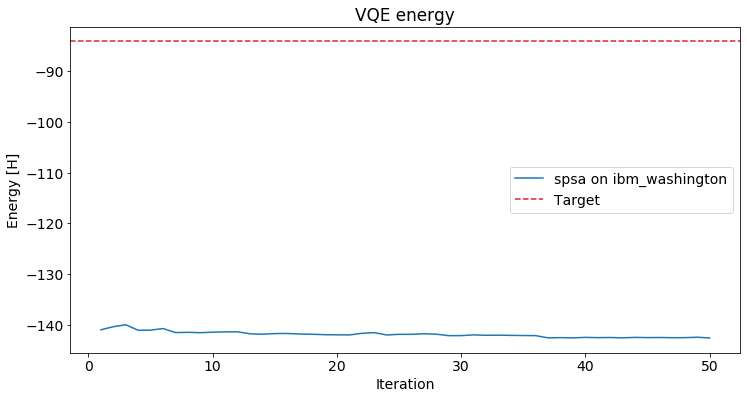

In [ ]:
plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(counts_real, values_real, label='spsa on ibm_washington')
plt.axhline(y=-84.206, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

It might be interesting to see what the default error mitigation of Qiskit Runtime won us. Let's set the resilience and optimization both to zero, and see what happens.

In [ ]:
counts = []
values = []

with Session(service=service, backend=backend) as session:
    options = Options()
    options.execution.shots = 2000
    options.resilience_level = 0
    options.optimization_level = 0

    vqe = VQE(Estimator(session=session, options=options),
              ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    print(result)

session.close()

In [ ]:
result_zero=result
values_zero = values
for i in range(len(values)):
    values_zero[i] = values[i]-60.66177520599246
counts_zero = counts

In [ ]:
#Not to be shown in walkthrough. Just for me to have.
f = open("qasm_spsa_H2O", "w+")
f.write("# optimization_step Energy\n")        # column names
numpy.savetxt(f, numpy.array([counts_zero, values_zero]).T)

In [ ]:
plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(counts_real, values_real, label='Default')
plt.plot(counts_zero, values_zero, label='Res=0,Opt=0')
plt.axhline(y=-84.206, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()